In [432]:
import websocket
import _thread
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [433]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def region_of_interest(image, vertices):
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

(120, 160, 3)


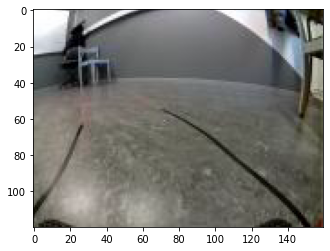

In [446]:
# image = cv2.imread('test_image/savedImage.jpg')
image = cv2.imread('images/img_600.png')
print(image.shape)
# cv2.imshow('result',image)
# cv2.waitKey(0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
img_height = image.shape[0]
img_width = image.shape[1]
lane_image = np.copy(image)

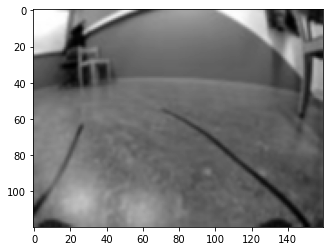

In [447]:
image1 = gaussian_blur(grayscale(image), 3)
plt.imshow(image1, cmap='gray')
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [448]:
## Define three different approaches of gradient threshold.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, 5)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F,1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F,0 ,1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, 5)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag_sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return mag_binary


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, 5)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

In [449]:
## Define color threshold for different channels
def hls_threshold(image, channel='s', thresh=(90, 255)):
    # Apply threshold to specified color channel
    # Output binary image
    img = np.copy(image)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:, :, 0]
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    if channel == 's':
        hls_binary = np.zeros_like(s_channel)
        hls_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    elif channel == 'l':
        hls_binary = np.zeros_like(l_channel)
        hls_binary[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    elif channel == 'h':
        hls_binary = np.zeros_like(h_channel)
        hls_binary[(h_channel >= thresh[0]) & (h_channel <= thresh[1])] = 1
    
    return hls_binary


def rgb_threshold(image, channel='r', thresh=(200, 255)):
    # Apply threshold to specified color channel
    # Output binary image
    rgb = np.copy(image)
    r_channel = rgb[:, :, 0]
    g_channel = rgb[:, :, 1]
    b_channel = rgb[:, :, 2]
    if channel == 'r':
        rgb_binary = np.zeros_like(r_channel)
        rgb_binary[(r_channel >= thresh[0]) & (r_channel <= thresh[1])] = 1
    elif channel == 'g':
        rgb_binary = np.zeros_like(g_channel)
        rgb_binary[(g_channel >= thresh[0]) & (g_channel <= thresh[1])] = 1
    elif channel == 'b':
        rgb_binary = np.zeros_like(b_channel)
        rgb_binary[(b_channel >= thresh[0]) & (b_channel <= thresh[1])] = 1
    
    return rgb_binary



def labBSelect(img, thresh=(155, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 100:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [468]:
def perspective_view(image):
    img_width = image.shape[1]
    img_height = image.shape[0]
    src_points = np.float32(
                            [[0, 0.8*img_height],
                            [0.2*img_width, 0.5*img_height],
                            [0.8*img_width, 0.5*img_height], 
                            [img_width, 0.8*img_height]])
    dst_points = np.float32(
                            [[(img_width/8-20), img_height], 
                            [(img_width/8), 0], 
                            [(img_width*7/8), 0], 
                            [(img_width*7/8+20), img_height]])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    # Minv = cv2.getPerspectiveTransform(dst_points, src_points)
    img_warped = cv2.warpPerspective(image, M, (img_width, img_height), cv2.INTER_LINEAR)
    return img_warped

In [469]:
img_warped = perspective_view(lane_image)
# img_warped = gaussian_blur(img_warped, 3)
plt.imshow(img_warped, cmap='gray')
plt.show()

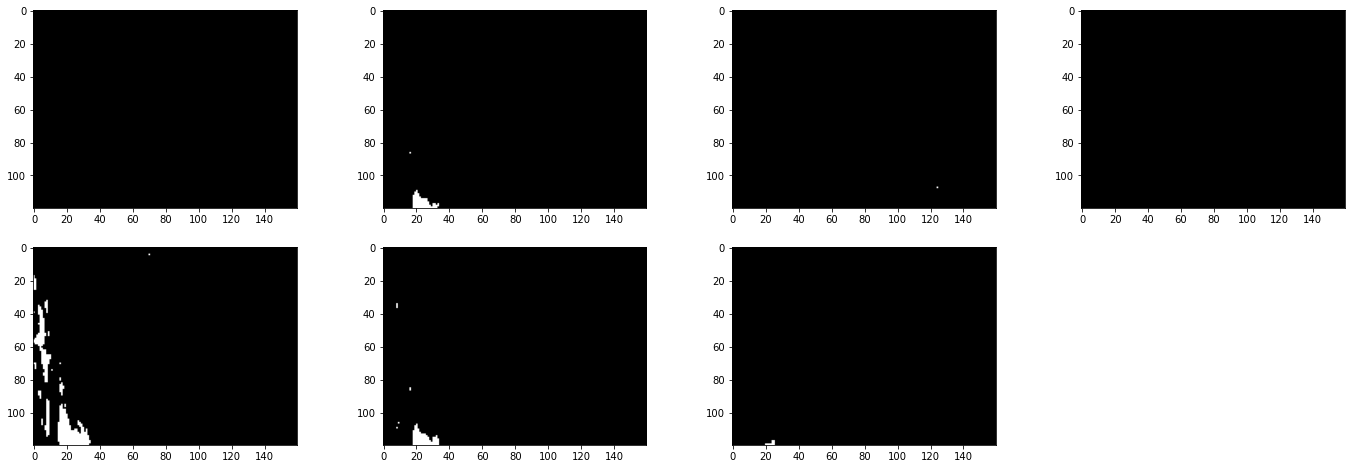

In [470]:
thresh = (150, 255)
h_channel = hls_threshold(img_warped, 'h', thresh)
l_channel = hls_threshold(img_warped, 'l', thresh)
s_channel = hls_threshold(img_warped, 's', thresh)

r_channel = rgb_threshold(img_warped,'r',thresh)
g_channel = rgb_threshold(img_warped, 'g', thresh)
b_channel = rgb_threshold(img_warped, 'b', thresh)

lab_b = labBSelect(img_warped,(40, 255))


plt.figure(figsize=(24,8))
plt.subplot(2, 4, 1)
plt.imshow(h_channel, cmap='gray')
plt.subplot(2, 4, 2)
plt.imshow(l_channel, cmap='gray')
plt.subplot(2, 4, 3)
plt.imshow(s_channel, cmap='gray')
plt.subplot(2, 4, 4)
plt.imshow(lab_b, cmap='gray')

plt.subplot(2, 4, 5)
plt.imshow(r_channel, cmap='gray')
plt.subplot(2, 4, 6)
plt.imshow(g_channel, cmap='gray')
plt.subplot(2, 4, 7)
plt.imshow(b_channel, cmap='gray')

In [471]:
sxbinary = abs_sobel_thresh(img_warped, sobel_kernel=5, thresh=(120,255))
meg_binary = mag_thresh(img_warped, sobel_kernel=5, mag_thresh=(120,255))
dir_binary = dir_threshold(img_warped, sobel_kernel=5, thresh=(0.8, 1.3))

plt.figure(figsize=(24,9))
plt.subplot(1, 3, 1)
plt.imshow(sxbinary, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(meg_binary, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(dir_binary, cmap='gray')

In [472]:
# Selection of filtering combinations

combined_binary = np.zeros_like(sxbinary)
# combined_binary[(s_channel == 1) | (sxbinary == 1)] = 1   # so far the best criteria
combined_binary[ (sxbinary == 1) | (meg_binary == 1) & (l_channel == 1)] = 1
plt.imshow(combined_binary, cmap='gray')

In [473]:
def init_findlane(binary_warped, nwindows=8, margin=100, minpix=50):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
#         # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window (`right` or `leftx_current`) on their mean position ###
        if (good_left_inds.size > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (good_right_inds.size > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

left_fit_init, right_fit_init = init_findlane(combined_binary, nwindows=8, margin=50, minpix=50)

<ipython-input-473-830ff0d2e1f3>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
<ipython-input-473-830ff0d2e1f3>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.2

In [474]:
def fit_poly(img_shape, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit_pix = np.polyfit(lefty, leftx, 2)
    right_fit_pix = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty_pix = np.linspace(0, img_shape[0]-1, img_shape[0])
    ploty_cr = ym_per_pix * ploty_pix    
    polyfit_pix = (left_fit_pix, right_fit_pix)
    polyfit_cr = (left_fit_cr, right_fit_cr)
    
    
    return polyfit_pix, polyfit_cr, ploty_pix, ploty_cr


def visualize_plot(left_line_pts, right_line_pts, left_fitx, right_fitx, ploty, out_img, window_img):

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    output_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    cv2.polylines(output_img, np.int_([left_pts]), False, (255, 255, 0), 5)
    cv2.polylines(output_img, np.int_([right_pts]), False, (255, 255, 0), 5)
    return output_img


def search_around_poly(binary_warped, left_fit_init, right_fit_init):
    
    margin = 50
    img_width = binary_warped.shape[1]
    ym_per_pix = 1 # meters per pixel in y dimension
    xm_per_pix = 1 # meters per pixel in x dimension
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_plotx =  left_fit_init[0] * nonzeroy ** 2 +  left_fit_init[1] * nonzeroy +  left_fit_init[2]
    right_poltx = right_fit_init[0] * nonzeroy ** 2 + right_fit_init[1] * nonzeroy + right_fit_init[2]
    
    left_lane_inds = (np.abs(nonzerox - left_plotx) < margin)  
    right_lane_inds = (np.abs(nonzerox - right_poltx) < margin)
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    polyfit_pix, polyfit_cr, ploty, ploty_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, ym_per_pix, xm_per_pix)
    polyfit_result = (polyfit_cr[0], polyfit_cr[1], ploty_cr)
    
    left_fit_pix = polyfit_pix[0]
    right_fit_pix = polyfit_pix[1]
    left_fitx =  left_fit_pix[0] * ploty ** 2 +  left_fit_pix[1] * ploty +  left_fit_pix[2]
    right_fitx = right_fit_pix[0] * ploty ** 2 + right_fit_pix[1] * ploty + right_fit_pix[2]
    
    lane_pts = (left_fitx, right_fitx, ploty)
    
    # determine vehicle position with respect to center
    # deviation = (0.5 * (left_fitx[-1] + right_fitx[-1]) - 0.5 * img_width) * xm_per_pix
    center_of_lane = 0.5 * (left_fitx[-1] + right_fitx[-1])
    
    return polyfit_result, center_of_lane, lane_pts

In [475]:
def measure_curvature_pixels(poly_coefficient):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    left_fit = poly_coefficient[0]
    right_fit = poly_coefficient[1]
    ploty = poly_coefficient[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curverad = (1 + (2*left_fit[0]*y_eval + left_fit[1]) ** 2) ** (3/2) / np.abs(2*left_fit[0])
    right_curverad = (1 + (2*right_fit[0]*y_eval + right_fit[1]) ** 2) ** (3/2) / np.abs(2*right_fit[0])
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
_, pos_dev, _ = search_around_poly(combined_binary, left_fit_init, right_fit_init)
# left_curverad, right_curverad = measure_curvature_pixels(polyfit_result)
# print(left_curverad, right_curverad, pos_dev)

print(pos_dev)

70.57562996555437
